In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU, SpatialDropout1D, CuDNNLSTM
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('You are using a normal-RAM runtime!')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 134.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# check if GPU is used
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16113014504011838608
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23928307712
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16556863729786354263
physical_device_desc: "device: 0, name: Quadro RTX 6000, pci bus id: 0000:19:00.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23928307712
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarna

2023-07-31 15:03:58.112630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 15:04:00.163168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 22819 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-07-31 15:04:00.164333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:1 with 22819 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-31 15:04:00.165412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:2 with 22819 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:67:00.0, co

In [4]:
# import the dataset from the Dataset folder
df = pd.read_csv('NFR_CSV.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  914 non-null    object
 1   sentence    914 non-null    object
dtypes: object(2)
memory usage: 14.4+ KB


In [5]:
df.class_name.value_counts()

Security           354
Usability          157
Operability        153
Maintainability    137
Performance        113
Name: class_name, dtype: int64

In [6]:
#function to print out a specific observation by passing the index of that in the dataset
def print_plot(index):
    example = df[df.index == index][['sentence', 'class_name']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Req_Class:', example[1])
print_plot(10)

The maximum wait time for a user navigating from one screen to another within the Disputes application shall be no more than 5 seconds.
Req_Class: Performance


In [7]:
# shows how the CSV is organized for the first 5 values
df.head(5)

,class_name,sentence
0,Performance,The system shall refresh the display every 60 ...
1,Performance,The product shall respond fast to keep up-to-d...
2,Performance,The product shall produce search results in an...
3,Performance,The search results shall be returned no later ...
4,Performance,The product shall generate a CMA report in an ...


In [8]:
df.groupby('class_name').describe()

sentence         \
                   count unique   
class_name                        
Maintainability      137    136   
Operability          153    125   
Performance          113     97   
Security             354    326   
Usability            157    139   

                                                                         
                                                               top freq  
class_name                                                               
Maintainability  Promotional updates to the website should take...    2  
Operability      The system shall able to operate within a busi...    2  
Performance      The system shall refresh the display every 60 ...    2  
Security         All customer information will be stored on a s...    2  
Usability        All of the users shall be able to use the syst...    2

In [9]:
# adds a new column in the dataframe called num that gives a number to each NFR catagory
df['num'] = df['class_name'].apply(lambda x: 
0 if x == 'Maintainability' 
else 1 if x == 'Operability' 
else 2 if x == 'Performance'
else 3 if x == 'Security' 
else 4)
df.groupby('num').describe()

class_name                              sentence         \
         count unique              top freq    count unique   
num                                                           
0          137      1  Maintainability  137      137    136   
1          153      1      Operability  153      153    125   
2          113      1      Performance  113      113     97   
3          354      1         Security  354      354    326   
4          157      1        Usability  157      157    139   

                                                             
                                                   top freq  
num                                                          
0    Promotional updates to the website should take...    2  
1    The system shall able to operate within a busi...    2  
2    The system shall refresh the display every 60 ...    2  
3    All customer information will be stored on a s...    2  
4    All of the users shall be able to use the syst...    2

In [10]:
# downloads and imports the pre-trained bert preprossessing model and encoder locally from tensorflow hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4")

2023-07-31 15:04:00.552645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22819 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-07-31 15:04:00.553418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22819 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-31 15:04:00.554197: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22819 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-07-31 15:04:00.554991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22580 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:68:00.0, comp

In [11]:
# a function that passes in a sentence and gets the bert generated embedings back
# this will return a dictionary and we need to specify that we want the pooled_output key
# pooled_output will generate an embding for the entire sentence which is what we need for identifying NFR catagory
def get_sentence_embeding(sentence):
    preprocessed_text = bert_preprocess(sentence)
    return bert_encoder(preprocessed_text)['pooled_output']

# example
get_sentence_embeding(["The system shall refresh the display every 60 seconds."])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.7198533 ,  0.49324065,  0.9997937 , -0.9842905 ,  0.9309974 ,
         0.9011457 ,  0.9539571 , -0.9941107 , -0.9505348 , -0.6419706 ,
         0.9552405 ,  0.9947908 , -0.99880844, -0.9996489 ,  0.68617326,
        -0.9447207 ,  0.97997385, -0.5733212 , -0.99990946, -0.7135597 ,
        -0.5616601 , -0.9996949 ,  0.25209156,  0.96349156,  0.95669603,
         0.0203095 ,  0.9672602 ,  0.999885  ,  0.78554535, -0.3534869 ,
         0.21141887, -0.9796004 ,  0.8662979 , -0.9979935 ,  0.10573205,
         0.36670557,  0.6996465 , -0.2325713 ,  0.8581782 , -0.93005544,
        -0.64867085, -0.6430388 ,  0.61907995, -0.5791381 ,  0.8974827 ,
         0.27057308,  0.09767482, -0.03348646, -0.11660355,  0.99975425,
        -0.93366176,  0.9805989 , -0.9965813 ,  0.97650355,  0.98308116,
         0.53378475,  0.9866402 ,  0.18060233, -0.99893564,  0.33495522,
         0.9387185 ,  0.25676188,  0.8893442 , -0.00723227,  0.35578674,
 

In [12]:
# generates a dictionary of bert embedings from all sentences in the dataset
embeding_dictionary = get_sentence_embeding(df['sentence'].values)
# get_sentence_embeding(df['sentence'].values)

In [13]:
# a function that passes in a sentence and gets the bert preprocessing tokens back
# this will return a dictionary of tokenized word embedings that can be fed into a bert model
def get_sentence_tokens(sentence):
    return bert_preprocess(sentence)
# example
get_sentence_tokens(["The system shall refresh the display every 60 seconds."])

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[  101,  1109,  1449,  4103,  1231,  2087, 21298,  1103,  3934,
          1451,  2539,  3071,   119,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0, 

In [14]:
# generates a dictionary of bert tokens from all sentences in the dataset
# token_dictionary = get_sentence_tokens(df['sentence'].values)
get_sentence_tokens(df['sentence'].values)

{'input_type_ids': <tf.Tensor: shape=(914, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(914, 128), dtype=int32, numpy=
 array([[  101,  1109,  1449, ...,     0,     0,     0],
        [  101,  1109,  3317, ...,     0,     0,     0],
        [  101,  1109,  3317, ...,     0,     0,     0],
        ...,
        [  101, 11696,  1103, ...,     0,     0,     0],
        [  101,  6849,  1116, ...,     0,     0,     0],
        [  101,  1109,  1449, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(914, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ...

In [43]:
# makes X the dictionary of each sentences embeding
X = np.array(embeding_dictionary)
X = pad_sequences(X, maxlen=768)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (914, 768)


In [16]:
# makes Y the dictionary of each sentences NFR catagory (a number unqiqe to identifying class_name)
Y = np.array(pd.get_dummies(df['class_name']).values)
print('Shape of label tensor:', Y.shape)
y, y_uniques=pd.factorize(df['class_name'], sort=True)
print(y)
print(Y)

Shape of label tensor: (914, 5)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3

In [17]:
# Split the data into training and testing sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=34, stratify=Y)
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(X, y, test_size=0.10, random_state=34, stratify=Y)

# Print the shapes of the training and testing sets.
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_train_n.shape, Y_train_n.shape)
print(X_test_n.shape, Y_test_n.shape)

# Print the target variables for the training and testing sets.
print(Y_train, Y_test)
print(Y_train_n, Y_test_n)

# Extract the 'sentence' column values from the DataFrame 'df'.
original_text_t = df['sentence'].tolist()  # This will create a list containing all the 'sentence' values.

# access the values from 'original_text_t'
for i in range(0, len(original_text_t)):
    temp = []
    for j in range(0, len(original_text_t[i])):
        if original_text_t[i][j] is not None:
            temp.append(original_text_t[i][j])
    original_text_t[i] = temp


(822, 768) (822, 5)
(92, 768) (92, 5)
(822, 768) (822,)
(92, 768) (92,)
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 1 0 0]
 ...
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]] [[0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]

In [18]:
def test_class(i):
    switcher={
            0:'Main',
            1:'Oper',
            2:'Perf',
            3:'Secu',
            4:'Usab'
         }
    return switcher.get(i,"Invalid class")

In [19]:
def make_con_mat(cf_matrix, class_name):
    plt.title("Confusion Matrix Heat Map for class: %s" % class_name)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [33]:
def create_model():
    model = Sequential()
    # 914 BERT embeddings of dimension 768 as input
    input_shape = (914, 768)
    model.add(Embedding(input_dim=914, output_dim=768))

    # Dropout layer for regularization
    # model.add(Dropout(0.2))
    model.add(SpatialDropout1D(0.2))
    
    # LSTM layer with 100 units
    model.add(LSTM(100, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    
    # Output layer with 5 nodes representing label predictions
    model.add(Dense(5, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model
model = create_model()
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 768)         701952    
                                                                 
 spatial_dropout1d_17 (Spati  (None, None, 768)        0         
 alDropout1D)                                                    
                                                                 
 lstm_13 (LSTM)              (None, 100)               347600    
                                                                 
 dense_13 (Dense)            (None, 5)                 505       
                                                                 
Total params: 1,050,057
Trainable params: 1,050,057
Non-trainable params: 0
_________________________________________________________________
None


In [48]:

def create_bert_model():
    # Define input shape for BERT embeddings
    input_shape = (768, 768)  # Replace 768 with the actual BERT embeddings dimension

    model = Sequential()
    model.add(Embedding(trainable=False, input_length=X.shape))
    model.add(SpatialDropout1D(0.2, input_shape=input_shape))
    model.add(CuDNNLSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

model = create_model()
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 768)         701952    
                                                                 
 spatial_dropout1d_25 (Spati  (None, None, 768)        0         
 alDropout1D)                                                    
                                                                 
 lstm_21 (LSTM)              (None, 100)               347600    
                                                                 
 dense_21 (Dense)            (None, 5)                 505       
                                                                 
Total params: 1,050,057
Trainable params: 1,050,057
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
# def create_model():
#     model = Sequential()
#     # 914 BERT embeddings of dimension 768 as input
#     input_shape = (914, 768)
    
#     # LSTM layer with 100 units
#     model.add(LSTM(100, input_shape=input_shape, dropout=0.2, recurrent_dropout=0.2))
    
#     # Dropout layer for regularization
#     model.add(Dropout(0.2))
#     # model.add(SpatialDropout1D(0.2))
    
#     # Output layer with 5 nodes representing label predictions
#     model.add(Dense(5, activation='softmax'))
    
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
#     return model
# model = create_model()
# print(model.summary())

In [49]:
# fix random seed for reproducibility
seed = 123
batch_size = 30
# define 10-fold cross validation test 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscorespre = []
cvscoresrec = []
cvscoresauc = []
cvscoresf1=[]
for train_index, val_index in kfold.split(X_train,Y_train_n):
    print("TRAIN:", train_index, "VAL:", val_index) 
    X_train_k, X_val = X_train[train_index], X_train[val_index]
    Y_train_k, Y_val = Y_train[train_index], Y_train[val_index]
    print(X_train_k, X_val, Y_train_k, Y_val)
    model=create_model()
    history=model.fit(X_train_k, Y_train_k,epochs=20,batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    scores=model.evaluate(X_val,Y_val)
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100))
    cvscoresauc.append(scores[2] * 100)
    cvscorespre.append(scores[3] * 100)
    cvscoresrec.append(scores[4] * 100)
    cvscoresf1.append(2*(scores[3]*scores[4])/(scores[3]+scores[4]+tf.keras.backend.epsilon()) * 100)
    Y_pred=model.predict(X_val)
    Y_pred_cm = (Y_pred.argmax(1)[:,None] == np.arange(Y_pred.shape[1])).astype(int)
    con_mat = multilabel_confusion_matrix(Y_val, Y_pred_cm, labels=[0, 1, 2, 3, 4])

TRAIN: [  0   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19  20  21
  22  23  24  25  26  28  29  30  31  33  34  35  36  37  38  40  41  42
  43  45  46  47  48  49  50  51  52  53  54  55  56  58  59  60  61  62
  63  64  65  66  68  69  70  72  73  74  75  76  77  78  80  81  82  83
  84  85  86  87  88  90  91  92  93  94  96  97  98  99 100 101 102 103
 104 106 107 108 109 110 111 112 113 114 115 116 118 119 120 121 122 123
 124 125 126 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 148 150 151 152 153 154 156 157 159 160 161 163 164 165
 166 167 168 169 170 171 172 174 176 177 178 179 180 181 182 183 184 185
 187 188 189 190 191 192 193 195 196 198 199 200 201 202 203 204 205 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 255 256 259 260 261 262 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278

Epoch 1/20
23/23 [==============================] - 48s 2s/step - loss: 1.5402 - acc: 0.3820 - auc_22: 0.6164 - precision_22: 0.4348 - recall_22: 0.0150 - val_loss: 1.6189 - val_acc: 0.3378 - val_auc_22: 0.5473 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 43s 2s/step - loss: 1.5124 - acc: 0.3940 - auc_22: 0.6354 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - val_loss: 1.6105 - val_acc: 0.3378 - val_auc_22: 0.5507 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 43s 2s/step - loss: 1.5141 - acc: 0.3940 - auc_22: 0.6383 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - val_loss: 1.6294 - val_acc: 0.3378 - val_auc_22: 0.5541 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 44s 2s/step - loss: 1.5055 - acc: 0.3940 - auc_22: 0.6438 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - val_loss: 1

Epoch 1/20
23/23 [==============================] - 44s 2s/step - loss: 1.5324 - acc: 0.3850 - auc_23: 0.6314 - precision_23: 0.3871 - recall_23: 0.0541 - val_loss: 1.6295 - val_acc: 0.3108 - val_auc_23: 0.5270 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 43s 2s/step - loss: 1.5141 - acc: 0.3955 - auc_23: 0.6423 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00 - val_loss: 1.6082 - val_acc: 0.3108 - val_auc_23: 0.5338 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 42s 2s/step - loss: 1.5129 - acc: 0.3955 - auc_23: 0.6274 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00 - val_loss: 1.6299 - val_acc: 0.3108 - val_auc_23: 0.5270 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 43s 2s/step - loss: 1.5056 - acc: 0.3955 - auc_23: 0.6421 - precision_23: 0.0000e+00 - recall_23: 0.0000e+00 - val_loss: 1

Epoch 1/20
23/23 [==============================] - 48s 2s/step - loss: 1.5264 - acc: 0.3799 - auc_24: 0.6337 - precision_24: 0.3556 - recall_24: 0.0240 - val_loss: 1.6144 - val_acc: 0.3243 - val_auc_24: 0.5541 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 44s 2s/step - loss: 1.5084 - acc: 0.3934 - auc_24: 0.6472 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_loss: 1.6131 - val_acc: 0.3243 - val_auc_24: 0.5439 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 45s 2s/step - loss: 1.5114 - acc: 0.3934 - auc_24: 0.6305 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_loss: 1.6162 - val_acc: 0.3243 - val_auc_24: 0.5541 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 44s 2s/step - loss: 1.5128 - acc: 0.3934 - auc_24: 0.6401 - precision_24: 0.0000e+00 - recall_24: 0.0000e+00 - val_loss: 1

Epoch 1/20
23/23 [==============================] - 43s 2s/step - loss: 1.5352 - acc: 0.3874 - auc_25: 0.6273 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - val_loss: 1.5793 - val_acc: 0.3649 - val_auc_25: 0.5743 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 42s 2s/step - loss: 1.5271 - acc: 0.3889 - auc_25: 0.6228 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - val_loss: 1.5614 - val_acc: 0.3649 - val_auc_25: 0.5811 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 42s 2s/step - loss: 1.5207 - acc: 0.3889 - auc_25: 0.6345 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - val_loss: 1.5615 - val_acc: 0.3649 - val_auc_25: 0.5811 - val_precision_25: 0.0000e+00 - val_recall_25: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 42s 2s/step - loss: 1.5114 - acc: 0.3889 - auc_25: 0.6358 - precision_25: 0.0000e+00 - recall_25: 0.0000e+00 - val

Epoch 1/20
23/23 [==============================] - 43s 2s/step - loss: 1.5376 - acc: 0.3814 - auc_26: 0.6178 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - val_loss: 1.5786 - val_acc: 0.3378 - val_auc_26: 0.5709 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 42s 2s/step - loss: 1.5181 - acc: 0.3919 - auc_26: 0.6286 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - val_loss: 1.6097 - val_acc: 0.3378 - val_auc_26: 0.5439 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 42s 2s/step - loss: 1.5113 - acc: 0.3919 - auc_26: 0.6364 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00 - val_loss: 1.5988 - val_acc: 0.3378 - val_auc_26: 0.5355 - val_precision_26: 0.0000e+00 - val_recall_26: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 156ms/step - loss: 1.5091 - acc: 0.3902 - auc_26: 0.6402 - precision_26: 0.0000e+00 - recall_26: 0.0000e+00
auc_2

Epoch 1/20
23/23 [==============================] - 46s 2s/step - loss: 1.5318 - acc: 0.3844 - auc_27: 0.6308 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - val_loss: 1.5485 - val_acc: 0.3649 - val_auc_27: 0.5912 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 44s 2s/step - loss: 1.5181 - acc: 0.3889 - auc_27: 0.6292 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - val_loss: 1.5672 - val_acc: 0.3649 - val_auc_27: 0.5777 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 44s 2s/step - loss: 1.5293 - acc: 0.3889 - auc_27: 0.6211 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00 - val_loss: 1.5564 - val_acc: 0.3649 - val_auc_27: 0.5811 - val_precision_27: 0.0000e+00 - val_recall_27: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 1s 157ms/step - loss: 1.5104 - acc: 0.3902 - auc_27: 0.6402 - precision_27: 0.0000e+00 - recall_27: 0.0000e+00
auc_2

Epoch 1/20
23/23 [==============================] - 48s 2s/step - loss: 1.5254 - acc: 0.3769 - auc_28: 0.6288 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - val_loss: 1.5949 - val_acc: 0.3649 - val_auc_28: 0.5777 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 43s 2s/step - loss: 1.5197 - acc: 0.3889 - auc_28: 0.6296 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - val_loss: 1.5606 - val_acc: 0.3649 - val_auc_28: 0.5743 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 43s 2s/step - loss: 1.5152 - acc: 0.3889 - auc_28: 0.6365 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - val_loss: 1.5674 - val_acc: 0.3649 - val_auc_28: 0.5743 - val_precision_28: 0.0000e+00 - val_recall_28: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 44s 2s/step - loss: 1.5143 - acc: 0.3889 - auc_28: 0.6358 - precision_28: 0.0000e+00 - recall_28: 0.0000e+00 - val

Epoch 1/20
23/23 [==============================] - 46s 2s/step - loss: 1.5337 - acc: 0.3769 - auc_29: 0.6271 - precision_29: 0.2830 - recall_29: 0.0225 - val_loss: 1.5924 - val_acc: 0.3514 - val_auc_29: 0.5676 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 41s 2s/step - loss: 1.5106 - acc: 0.3904 - auc_29: 0.6415 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - val_loss: 1.5812 - val_acc: 0.3514 - val_auc_29: 0.5709 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 41s 2s/step - loss: 1.5139 - acc: 0.3904 - auc_29: 0.6379 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - val_loss: 1.5640 - val_acc: 0.3514 - val_auc_29: 0.5709 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 42s 2s/step - loss: 1.5146 - acc: 0.3904 - auc_29: 0.6368 - precision_29: 0.0000e+00 - recall_29: 0.0000e+00 - val_loss: 1

Epoch 1/20
23/23 [==============================] - 46s 2s/step - loss: 1.5475 - acc: 0.3829 - auc_30: 0.6176 - precision_30: 0.3333 - recall_30: 0.0075 - val_loss: 1.5480 - val_acc: 0.3649 - val_auc_30: 0.5743 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 42s 2s/step - loss: 1.5166 - acc: 0.3889 - auc_30: 0.6359 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - val_loss: 1.5867 - val_acc: 0.3649 - val_auc_30: 0.5574 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 43s 2s/step - loss: 1.5115 - acc: 0.3889 - auc_30: 0.6429 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00 - val_loss: 1.5787 - val_acc: 0.3649 - val_auc_30: 0.5574 - val_precision_30: 0.0000e+00 - val_recall_30: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 0s 159ms/step - loss: 1.5136 - acc: 0.3902 - auc_30: 0.6402 - precision_30: 0.0000e+00 - recall_30: 0.0000e+00
auc_30: 64.02

Epoch 1/20
23/23 [==============================] - 46s 2s/step - loss: 1.5156 - acc: 0.3799 - auc_31: 0.6374 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val_loss: 1.6493 - val_acc: 0.3378 - val_auc_31: 0.5507 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 2/20
23/23 [==============================] - 43s 2s/step - loss: 1.5090 - acc: 0.3934 - auc_31: 0.6409 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val_loss: 1.6190 - val_acc: 0.3378 - val_auc_31: 0.5473 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 3/20
23/23 [==============================] - 44s 2s/step - loss: 1.5116 - acc: 0.3934 - auc_31: 0.6285 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val_loss: 1.5914 - val_acc: 0.3378 - val_auc_31: 0.5507 - val_precision_31: 0.0000e+00 - val_recall_31: 0.0000e+00
Epoch 4/20
23/23 [==============================] - 44s 2s/step - loss: 1.5078 - acc: 0.3934 - auc_31: 0.6355 - precision_31: 0.0000e+00 - recall_31: 0.0000e+00 - val

In [50]:
print("Mean & std for Area under Curve: %.2f%% (+/- %.2f%%)" % (np.mean(cvscoresauc), np.std(cvscoresauc)))
print("Mean & std for Precision: %.2f%% (+/- %.2f%%)" % (np.mean(cvscorespre), np.std(cvscorespre)))
print("Mean & std for Recall: %.2f%% (+/- %.2f%%)" % (np.mean(cvscoresrec), np.std(cvscoresrec)))
print(("Mean & std for F1 score: %.2f%% (+/- %.2f%%)" % (np.mean(cvscoresf1), np.std(cvscoresf1))))

Mean & std for Area under Curve: 63.60% (+/- 0.51%)
Mean & std for Precision: 0.00% (+/- 0.00%)
Mean & std for Recall: 0.00% (+/- 0.00%)
Mean & std for F1 score: 0.00% (+/- 0.00%)


Maximum Training Accuracy: 0.3933933973312378
Maximum Validation Accuracy: 0.3378378450870514
Minimum Training Loss: 1.5091960430145264
Minimum Validation Loss: 1.580735683441162


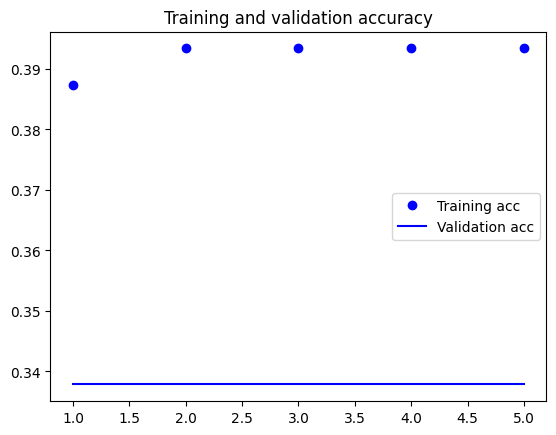

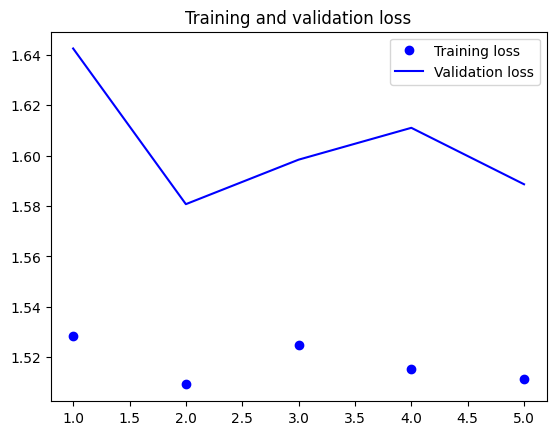

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

print("Maximum Training Accuracy: %s" % np.max(history.history['acc']))
print("Maximum Validation Accuracy: %s" % np.max(history.history['val_acc']))
print("Minimum Training Loss: %s"  % np.min(history.history['loss']))
print("Minimum Validation Loss: %s" % np.min(history.history['val_loss']))

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3/3 [==============================] - 1s 171ms/step - loss: 1.5122 - acc: 0.3913 - auc_10: 0.6386 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00
Test set
  Loss: 1.512
  Accuracy: 0.391
3/3 [==============================] - 1s 167ms/step
[[0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [0.17339379 0.17083691 0.12694076 0.34691188 0.18191674]
 [

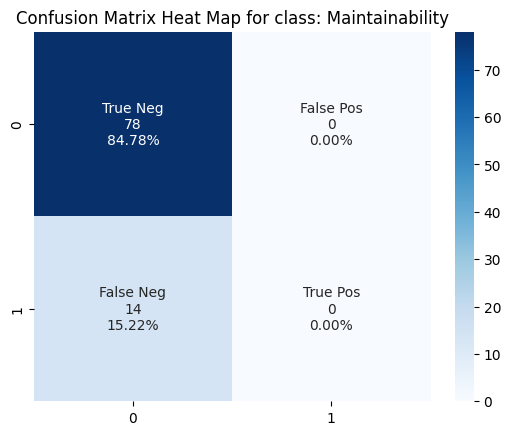

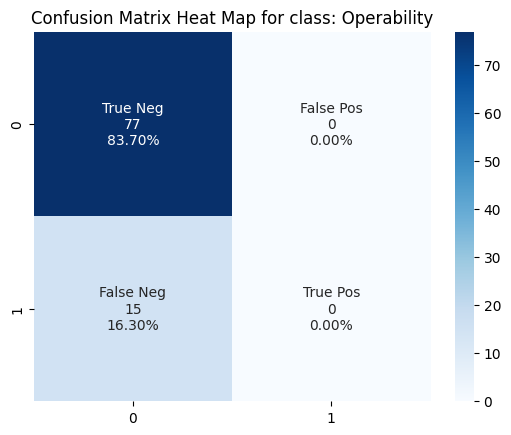

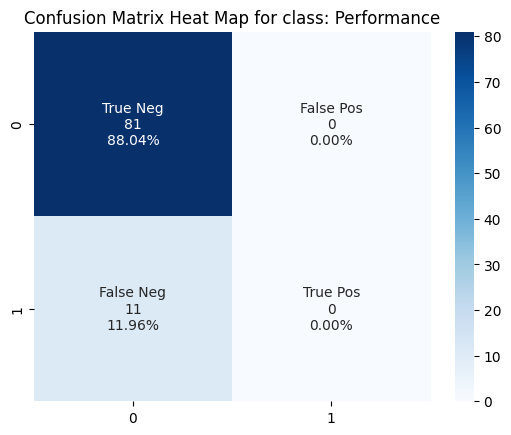

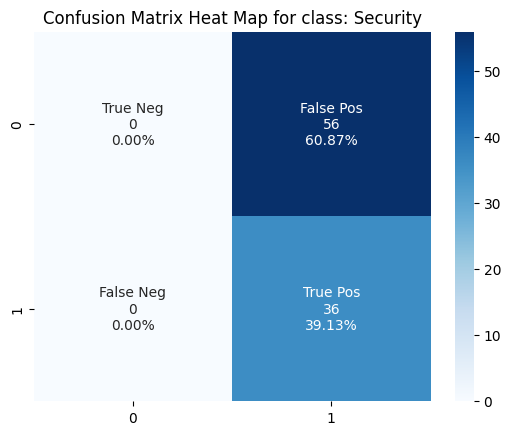

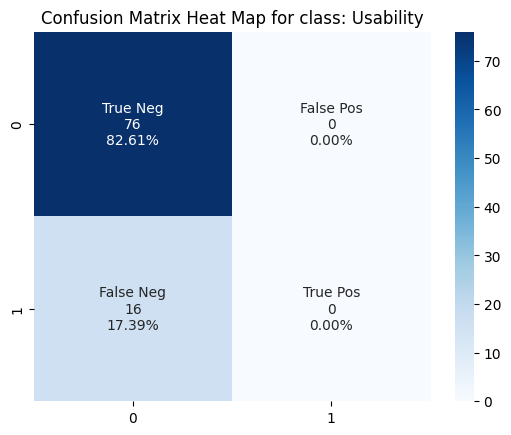

In [26]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
Y_pred_test=model.predict(X_test)
print(Y_pred_test)
Y_pred_test_cm = (Y_pred_test.argmax(1)[:,None] == np.arange(Y_pred_test.shape[1])).astype(int)
con_mat_test = multilabel_confusion_matrix(Y_test, Y_pred_test_cm, labels=[0, 1, 2, 3, 4])
plt.figure()
print("****************************Confustion Matrix Plots Start here for Test Data**************")
class_name = "Maintainability"
make_con_mat(con_mat_test[0],class_name)
plt.figure()
class_name = "Operability"
make_con_mat(con_mat_test[1], class_name)
plt.figure()
class_name = "Performance"
make_con_mat(con_mat_test[2],class_name)
plt.figure()
class_name = "Security"
make_con_mat(con_mat_test[3], class_name)
plt.figure()
class_name = "Usability"
make_con_mat(con_mat_test[4],class_name)